In [1]:
import numpy as np 
import os
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.layers import Input, Dense,  Dropout
from keras.models import Model
from keras import optimizers
from keras.utils import to_categorical
import spacy
import gensim
from gensim.models import Word2Vec
import re
import codecs
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Preprocessing functions

In [2]:
def build_path_list_labels(folder_path):
    """ Creates list of documents file path and list of corresponding labels for a given folder.
    """
    paths = []
    labels = []
    label = 0
    cat = os.listdir(folder_path)
    cat.sort()
    if '.DS_Store' in cat:
        cat.remove('.DS_Store')
    for categorie in cat:
        categorie_path = folder_path + categorie + '/'
        for file_id in os.listdir(categorie_path):
            paths.append(categorie_path + file_id)
            labels.append(label)
        label += 1
    return paths, np.array(labels)

# NLP Basic preprocessing tasks

def clean_doc(doc):
    """ Removes email addresses, jump of lign and quotes.
    """
    doc = re.sub('\S*@\S*\s?', '', doc)
    doc = re.sub('\s+', ' ', doc)
    doc = re.sub("\'", "", doc)
    return doc

def remove_stop_words(corpus, stop_words):
    """ Removes useless words for content classification.
    """
    clean_corpus = []
    for doc in corpus:
        clean_corpus.append([word for word in doc if word not in stop_words])
    return clean_corpus

def lemmatization(texts, lemmatizer, keep=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """ Convert text sequence into lemma sequence.
    """
    texts_out = []
    for sent in texts:
        doc = lemmatizer(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in keep])
    return texts_out

def preprocess_docs(paths):
    """ Apply preprocess functions to all text files in list of paths.
    """
    lemmatizer = spacy.load('en', disable=['parser', 'ner'])
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're'])
    corpus = [text_to_word_sequence(clean_doc(codecs.open(path, 'r', encoding='cp1252').read())) for path in paths]
    corpus_nostop = remove_stop_words(corpus, stop_words)
    return lemmatization(corpus_nostop, lemmatizer)

def word2vec_embed(data, tokenizer, word2vec):
    """ Embedds a document as the tfidf weighted mean of the word2vec embeddings of words in the document.
    """
    encoded_docs = []
    tfidf = tokenizer.texts_to_matrix(data, mode='tfidf')
    for i,doc in enumerate(data):
        encoded_doc = np.average([word2vec.wv[w] for w in doc if w in word2vec.wv], 
                                  axis=0, 
                                  weights=tfidf[i,np.array([tokenizer.word_index[w] for w in doc if w in word2vec.wv])])
        encoded_docs.append(encoded_doc)
    return np.array(encoded_docs)


def build_model(input_dim):
    """ Creates fully connected classifier.
    """
    x_input = Input(shape=(input_dim,))
    x = Dense(512, activation='relu')(x_input)
    x = Dropout(rate=0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.3)(x)
    output = Dense(20, activation='softmax')(x)
    
    model = Model(inputs=x_input, outputs=output)
    optimizer = optimizers.adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Evaluating solution

### Preprocessing data

In [3]:
# Parameters for the embedding
vocab_size = 10000
embedding_size = 200


print('Loading and preprocessing train data...')
train_folder = '20news-bydate/20news-bydate-train/'
train_paths, ytrain = build_path_list_labels(train_folder)
train_preprocessed = preprocess_docs(train_paths)
print('Training data loaded')

print('Loading and preprocessing test data...')
test_folder = '20news-bydate/20news-bydate-test/'
test_paths, ytest = build_path_list_labels(test_folder)
test_preprocessed = preprocess_docs(test_paths)
print('Test data loaded')

print('Training word2vec embedding and computing word counts for tfidf')
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_preprocessed)
word2vec = Word2Vec(train_preprocessed, size=embedding_size, sg=1, max_vocab_size=vocab_size)

Xtrain_vec = word2vec_embed(train_preprocessed, tokenizer, word2vec)
Xtrain_tfidf = tokenizer.texts_to_matrix(train_preprocessed, mode='tfidf')[:,1:vocab_size+1]
Xtrain = np.concatenate((Xtrain_vec, Xtrain_tfidf), axis=1)

Xtest_vec = word2vec_embed(test_preprocessed, tokenizer, word2vec)
Xtest_tfidf = tokenizer.texts_to_matrix(test_preprocessed, mode='tfidf')[:,1:vocab_size+1]
Xtest = np.concatenate((Xtest_vec, Xtest_tfidf), axis=1)
print('Embeddings computed for train and test data.')

Loading and preprocessing train data...
Training data loaded
Loading and preprocessing test data...
Test data loaded
Training word2vec embedding and computing word counts for tfidf
Embeddings computed for train and test data.


### Training and evaluating model

In [4]:
from tensorflow import set_random_seed
np.random.seed(0)
set_random_seed(0)

model = build_model(vocab_size)
model.fit(Xtrain_tfidf, to_categorical(ytrain), epochs=2, batch_size=128)

Epoch 1/2
11314/11314 [==============================] - 8s 745us/step - loss: 1.1720 - acc: 0.6905
Epoch 2/2
11314/11314 [==============================] - 8s 703us/step - loss: 0.1940 - acc: 0.9544


In [5]:
pred = np.argmax(model.predict(Xtest_tfidf), axis=1)
print('Test accuracy : {}'.format(np.mean(pred==ytest)))

Test accuracy : 0.828332448221


### Creating submission file

In [6]:
import csv

probs = model.predict(Xtest_tfidf)
labels = os.listdir(train_folder)
if '.DS_Store' in labels:
    labels.remove('.DS_Store')
labels.sort()

with open('submission.csv', 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['document_id'] + labels)
    for test_path, y_pred in zip(test_paths, probs):
        doc_id = test_path.split('/')[-1]
        writer.writerow([doc_id]+list(y_pred))

# Performance analysis

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Normalized Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This function was directly taken from an sklearn example.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=80)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text_info = format(cm[i, j], fmt) if cm[i,j] >= 0.01 else ''
        plt.text(j, i, text_info,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


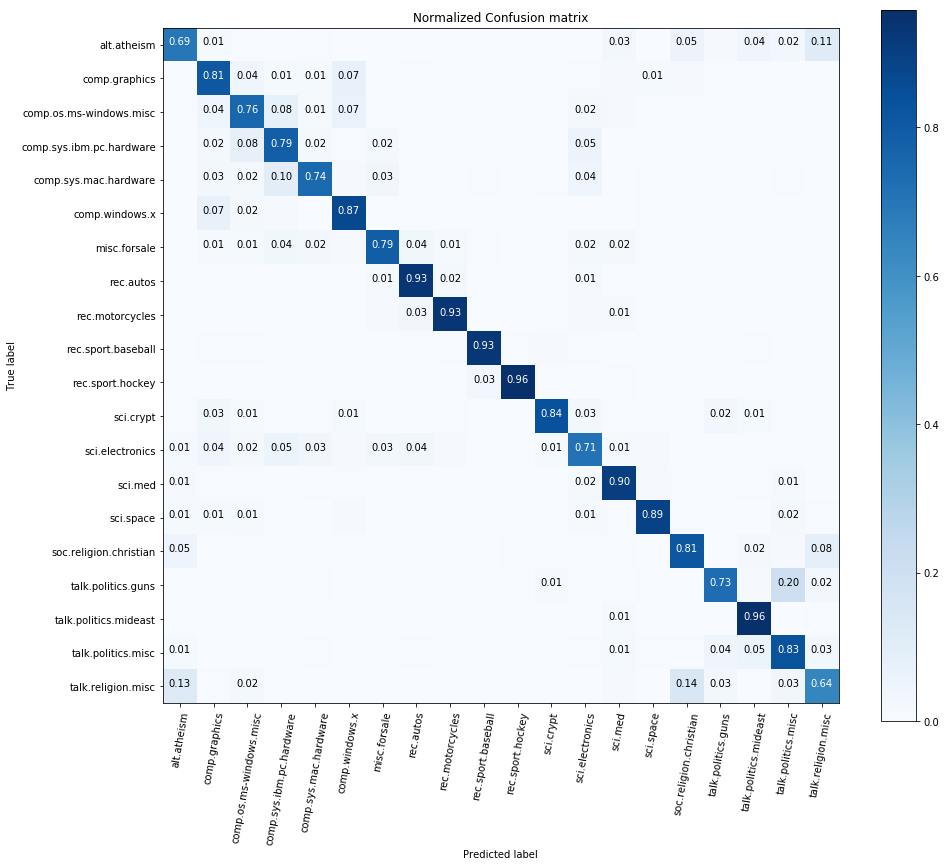

In [8]:
cm = confusion_matrix(pred, ytest)
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
fig.align_labels()
plot_confusion_matrix(cm, labels)